In [41]:
#| default_exp age_reference_plots

In [42]:
#| hide
from nbdev.showdoc import *

In [43]:
#| export
from pheno_utils.config import *

from typing import Dict, List, Callable, Optional, Union, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from scipy.stats import linregress
from sklearn.linear_model import HuberRegressor
from numpy import ndarray


In [44]:
#| export

try:
    importlib.import_module("pygam")
except ImportError:
    raise ImportError("The 'pygam' library is not installed. Please install it using 'pip install pygam' before running this script.")

from pygam import ExpectileGAM

In [45]:
#| export

def get_gam_expectiles(X: ndarray, y: ndarray, expectiles: List[float] = [0.03, 0.1, 0.5, 0.9, 0.97]) -> Tuple[ndarray, Dict[str, ndarray]]:
    """
    Fit Expectile Generalized Additive Models (GAMs) for given expectiles.

    Args:
        X (ndarray): Feature data for the model.
        y (ndarray): Target variable for the model.
        expectiles (List[float]): List of expectiles to fit. Default is [0.03, 0.1, 0.5, 0.9, 0.97].

    Returns:
        Tuple[ndarray, Dict[str, ndarray]]: A tuple containing a grid of X values for prediction and a dictionary with expectiles as keys and their corresponding model predictions as values.
    """

    # Fit the median model first by Cross-Validation
    gam50 = ExpectileGAM(expectile=0.5).gridsearch(X, y, progress=False)

    # Copy the smoothing to the other models
    lam = gam50.lam

    # Generate a grid of X values for prediction
    XX = gam50.generate_X_grid(term=0, n=500)

    # Initialize dictionary to store the GAM expectiles
    gam_expectiles = {}

    # Fit all wanted expectiles and store their predictions
    for expectile in expectiles:
      gam = ExpectileGAM(expectile=expectile, lam=lam).fit(X, y)
      gam_expectiles[expectile] = gam.predict(XX)

    return XX, gam_expectiles

In [58]:
#| export

class AgeRefPlot:
    def __init__(
        self,
        data: pd.DataFrame,
        val_col: str,
        age_col: str = "age_at_research_stage",
        sex_col: str = "sex",
        sex: Optional[int] = None,
        val_color: Optional[str] = None,
        ax_main: Optional[plt.Axes] = None,
        ax_agehist: Optional[plt.Axes] = None,
        ax_valhist: Optional[plt.Axes] = None,
        age_bins: Optional[np.ndarray] = None,
        val_bins: Optional[np.ndarray] = None,
        linear_fit: bool = True,
        expectiles: Optional[List] = [0.03, 0.1, 0.5, 0.9, 0.97],
        top_disp_perc: float = 99,
        bottom_disp_perc: float = 1,
        robust: bool = True,
        scale: float = 1.,
        transform: Optional[Callable] = None,
        make_fig: bool = True
    ) -> None:
        """
        Initializes the AgeRefPlot class.

        Args:
            data (pd.DataFrame): A pandas DataFrame containing the data.
            val_col (str): The name of the value column in the DataFrame.
            age_col (str): The name of the age column in the DataFrame.
            sex_col (str): The name of the sex column in the DataFrame.
            sex (Optional[int], optional): The sex to filter the data by. 0 for females and 1 for males. Defaults to None.
            val_color (Optional[str], optional): The color to use for the value plot. Defaults to None.
            ax_main (Optional[plt.Axes], optional): The main axis for the plot. Defaults to None.
            ax_agehist (Optional[plt.Axes], optional): The axis for the age histogram. Defaults to None.
            ax_valhist (Optional[plt.Axes], optional): The axis for the value histogram. Defaults to None.
            age_bins (Optional[np.ndarray], optional): The age bins for the histograms. Defaults to None.
            val_bins (Optional[np.ndarray], optional): The value bins for the histograms. Defaults to None.
            linear_fit (bool, optional): Whether to perform a linear fit on the data. Defaults to True.
            expectiles (Optional[List], optional): Whether to calculate and shpe gam expectiles or not. Defaults to [0.03, 0.1, 0.5, 0.9, 0.97].
            top_disp_perc (float, optional): The top percentile to use for display. Defaults to 99.
            bottom_disp_perc (float, optional): The bottom percentile to use for display. Defaults to 1.
            robust (bool, optional): Whether to use a robust regression method (HuberRegressor) instead of ordinary least squares for linear_fit. Defaults to True.
            scale (float, optional): The scaling factor for the value column. Defaults to 1.
            transform (Optional[Callable], optional): The transformation function to apply to the value column. Defaults
            make_fig (bool, optional): Whether to create a new figure if axes are not provided. Defaults to True.
        """
        self.data = data.dropna(subset=[age_col, val_col]).copy()
        self.data = self.data.sort_values(by=age_col)
        if transform is not None:
            self.data[val_col] = transform(self.data[val_col])
        self.data[val_col] = scale * self.data[val_col]
        self.val_col = val_col
        self.age_col = age_col
        self.sex_col = sex_col
        self.transform = transform
        self.scale = scale
        self.sex = sex
        self.linear_fit = linear_fit
        self.expectiles = expectiles
        # Cut data for display only removing outliers
        self.top_disp_perc = top_disp_perc/100
        self.bottom_disp_perc = bottom_disp_perc/100
        quantiles = self.data[[val_col]].quantile([self.bottom_disp_perc, self.top_disp_perc])
        self.disp_data = self.data[(self.data[val_col] > quantiles.loc[self.bottom_disp_perc, val_col]) &
                                   (self.data[val_col] < quantiles.loc[self.top_disp_perc, val_col])].copy()
        self.robust = robust
        self.slope = np.nan
        self.intercept = np.nan

        if val_color is None:
            self.val_color = {0: FEMALE_COLOR, 1: MALE_COLOR}.get(self.sex, ALL_COLOR)
        self.ref_color = REF_COLOR

        if age_bins is None:
            age_bins = np.arange(35, 75, 1)
        self.age_bins = age_bins
        self.min_age = self.age_bins[0]
        self.max_age = self.age_bins[-1]

        self.expectiles_dict = None

        if val_bins is None:
            val_bins = np.linspace(
                self.disp_data[self.val_col].min(), self.disp_data[self.val_col].max(), 50
            )
        self.val_bins = val_bins

        # Prep axes
        if (((ax_main is None) | (ax_agehist is None) | (ax_valhist is None)) & (make_fig==True)):
            ax_dict = plt.figure(
                constrained_layout=True, figsize=(7, 5)
            ).subplot_mosaic(
                """
            AAA.
            CCCE
            CCCE
            CCCE
            CCCE
            """,
                gridspec_kw={"wspace": 0, "hspace": 0},
            )
            self.ax_agehist = ax_dict["A"]
            self.ax_valhist = ax_dict["E"]
            self.ax_main = ax_dict["C"]

        else:
            self.ax_agehist = ax_agehist
            self.ax_valhist = ax_valhist
            self.ax_main = ax_main

    def plot_agehist(self):
        self.ax_agehist.hist(
            self.disp_data[self.age_col],
            bins=self.age_bins,
            facecolor=self.val_color,
            edgecolor="white",
            linewidth=0.5,
            alpha=0.8,
        )

    def plot_valhist(self):
        self.ax_valhist.hist(
            self.disp_data[self.val_col],
            orientation="horizontal",
            bins=self.val_bins,
            facecolor=self.val_color,
            edgecolor="white",
            linewidth=0.5,
            alpha=0.8,
        )

    def plot_scatter(self):
        self.ax_main.scatter(
            self.disp_data[self.age_col],
            self.disp_data[self.val_col],
            s=40,
            alpha=0.4,
            marker="o",
            facecolors="none",
            linewidths=1,
            color=self.val_color,
        )

    def plot_percentiles(self):
        # fetch percentiles if needed by fitting a GAM
        if self.expectiles_dict is None:
            X, y = self.data[[self.age_col]].values, self.data[self.val_col].values
            XX, self.expectiles_dict = get_gam_expectiles(X, y, self.expectiles)

        middle_index = len(self.expectiles) // 2

        # plot expectiles curves
        for perc_str in self.expectiles:
            perc_vector = self.expectiles_dict[perc_str]
            self.ax_main.plot(
                XX,
                perc_vector,
                color=self.ref_color,
                alpha=0.5,
                lw=2,
                ls=":",
            )
            self.ax_main.text(
                x=XX.max(),
                y=perc_vector[-1],
                s=perc_str,
                alpha=0.5,
            )

        # fill between curves
        if len(self.expectiles) > 2:
            self.ax_main.fill_between(
                XX.squeeze(),
                self.expectiles_dict[(self.expectiles[middle_index - 1])],
                self.expectiles_dict[(self.expectiles[middle_index + 1])],
                alpha=0.1,
                color=self.ref_color,
            )
        if len(self.expectiles) > 4:
            self.ax_main.fill_between(
                XX.squeeze(),
                self.expectiles_dict[(self.expectiles[middle_index - 2])],
                self.expectiles_dict[(self.expectiles[middle_index + 2])],
                alpha=0.05,
                color=self.ref_color,
            )

    def calc_linear_fit(self):
        # get coeffs of linear fit
        if self.robust:
            huber = HuberRegressor().fit(
                self.data[[self.age_col]].values, self.data[[self.val_col]].values.ravel()
            )
            self.slope = huber.coef_[0]
            self.intercept = huber.intercept_
            r_value = np.nan
            p_value = np.nan
            std_err = np.nan
        else:
            self.slope, self.intercept, r_value, p_value, std_err = linregress(
                self.data[self.age_col].values, self.data[self.val_col].values
            )
        return self.slope, self.intercept, r_value, p_value, std_err

    def plot_ornaments(self):
        ax_main_str = {0: "Females", 1: "Males"}.get(self.sex, "")
        if self.linear_fit:
            slope, intercept, r_value, p_value, std_err = self.calc_linear_fit()
            fit_str = "y={0:.3f}*age+{1:.3f}".format(slope, intercept)
            ax_main_str = ax_main_str + " " + self.val_col + "\n" + fit_str

        self.ax_main.text(
            0.05,
            0.9,
            ax_main_str,
            color="black",
            fontsize="x-large",
            weight="bold",
            ha="left",
            va="baseline",
            transform=self.ax_main.transAxes,
            # font="Roboto Condensed",
        )

    def plot(self):
        ax = self.ax_main
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.set_xlabel("Age")
        xticks = (np.sort(np.unique(np.floor(self.age_bins / 10) * 10))).astype(int)
        xticks = np.append(xticks, xticks[-1] + 10)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
        ax.set_xlim(xticks[0], xticks[-1] + 1)
        ax.set_ylabel(self.val_col)

        ax = self.ax_agehist
        self.ax_main.sharex(self.ax_agehist)
        ax.set_xticklabels([]), ax.set_yticks([])
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)

        ax = self.ax_valhist
        self.ax_main.sharey(self.ax_valhist)
        ax.set_yticklabels([]), ax.set_xticks([])
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["top"].set_visible(False)
        
        self.plot_scatter()
        self.plot_percentiles()
        self.plot_ornaments()
        self.plot_agehist()
        self.plot_valhist()

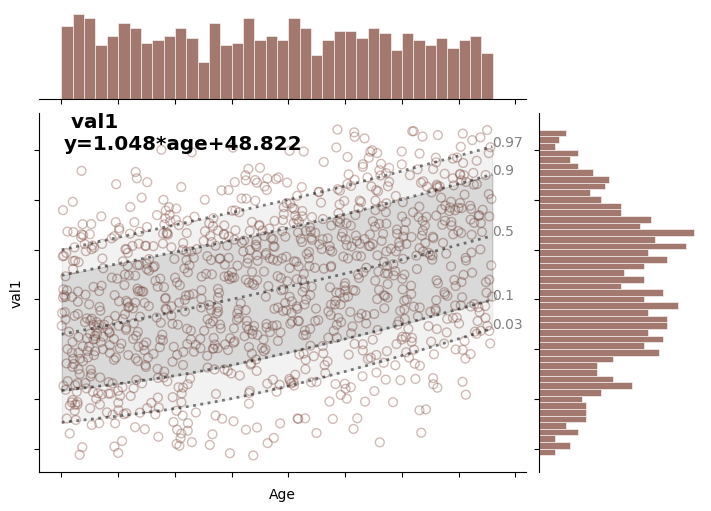

In [59]:
data = generate_synthetic_data(n=1000)


refplot = AgeRefPlot(data, "val1")
refplot.plot()

In [60]:
#| export

class GenderAgeRefPlot(AgeRefPlot):
    def __init__(
        self, 
        data: pd.DataFrame,
        val_col: str,
        age_col: str = "age_at_research_stage",
        sex_col: str = "sex",
        age_bins: Optional[np.ndarray] = None,
        val_bins: Optional[np.ndarray] = None,
        linear_fit: bool = True,
        expectiles: Optional[List] = [0.03, 0.1, 0.5, 0.9, 0.97],
        top_disp_perc: float = 99,
        bottom_disp_perc: float = 1,
        robust: bool = True,
        scale: float = 1.,
        transform: Optional[Callable] = None,
    ) -> None:
        """Initializes the GenderAgeRefPlot class.

        Args:
            data (pd.DataFrame): The input data containing age, value, and gender columns.
            val_col (str): The name of the value column in the data.
            age_col (str): The name of the age column in the DataFrame.
            sex_col (str): The name of the sex column in the DataFrame.
            age_bins (np.ndarray, optional): An array of age bin edges.
            val_bins (np.ndarray, optional): An array of value bin edges.
            linear_fit (bool, optional): Whether to fit a linear regression line. Defaults to True.
            expectiles (Optional[List], optional): Whether to calculate and shpe gam expectiles or not. Defaults to [0.03, 0.1, 0.5, 0.9, 0.97].
            top_disp_perc (float, optional): The top percentile for data display. Defaults to 99.
            bottom_disp_perc (float, optional): The bottom percentile for data display. Defaults to 1.
            robust (bool, optional): Whether to use a robust linear regression. Defaults to True.
            scale (float, optional): The scaling factor for the data. Defaults to 1.
            transform (Callable, optional): An optional function to apply to the data. Defaults to None.
        """
        super().__init__(
            data=data,
            val_col=val_col,
            age_col=age_col,
            sex_col=sex_col,
            age_bins=age_bins,
            val_bins=val_bins,
            linear_fit=linear_fit,
            expectiles=expectiles,
            top_disp_perc=top_disp_perc,
            bottom_disp_perc=bottom_disp_perc,
            robust=robust,
            scale=scale,
            transform=transform,
            make_fig=False
        )

    def plot(self) -> None:
        """Plots the data for both genders in separate panels."""
        ax_dict = plt.figure(constrained_layout=True, figsize=(16, 6)).subplot_mosaic(
            """
            AAA.BBB.
            CCCEDDDF
            CCCEDDDF
            CCCEDDDF
            CCCEDDDF
            """,
            gridspec_kw={"wspace": 0, "hspace": 0},
        )
        self.ax_dict = ax_dict

        self.female_refplot = AgeRefPlot(
            data=self.data[self.data["sex"]==0],
            val_col=self.val_col,
            age_col=self.age_col,
            sex_col=self.sex_col,
            sex=0,
            ax_main=ax_dict["C"],
            ax_agehist=ax_dict["A"],
            ax_valhist=ax_dict["E"],
            age_bins=self.age_bins,
            val_bins=self.val_bins,
            linear_fit=self.linear_fit,
            top_disp_perc=self.top_disp_perc*100,
            bottom_disp_perc=self.bottom_disp_perc*100,
            expectiles=self.expectiles,
            robust=self.robust,
        )
        self.female_refplot.plot()

        self.male_refplot = AgeRefPlot(
            data=self.data[self.data["sex"]==1],
            val_col=self.val_col,
            age_col=self.age_col,
            sex_col=self.sex_col,
            sex=1,
            ax_main=ax_dict["D"],
            ax_agehist=ax_dict["B"],
            ax_valhist=ax_dict["F"],
            age_bins=self.age_bins,
            val_bins=self.val_bins,
            linear_fit=self.linear_fit,
            top_disp_perc=self.top_disp_perc*100,
            bottom_disp_perc=self.bottom_disp_perc*100,
            expectiles=self.expectiles,
            robust=self.robust,
        )
        self.male_refplot.plot()

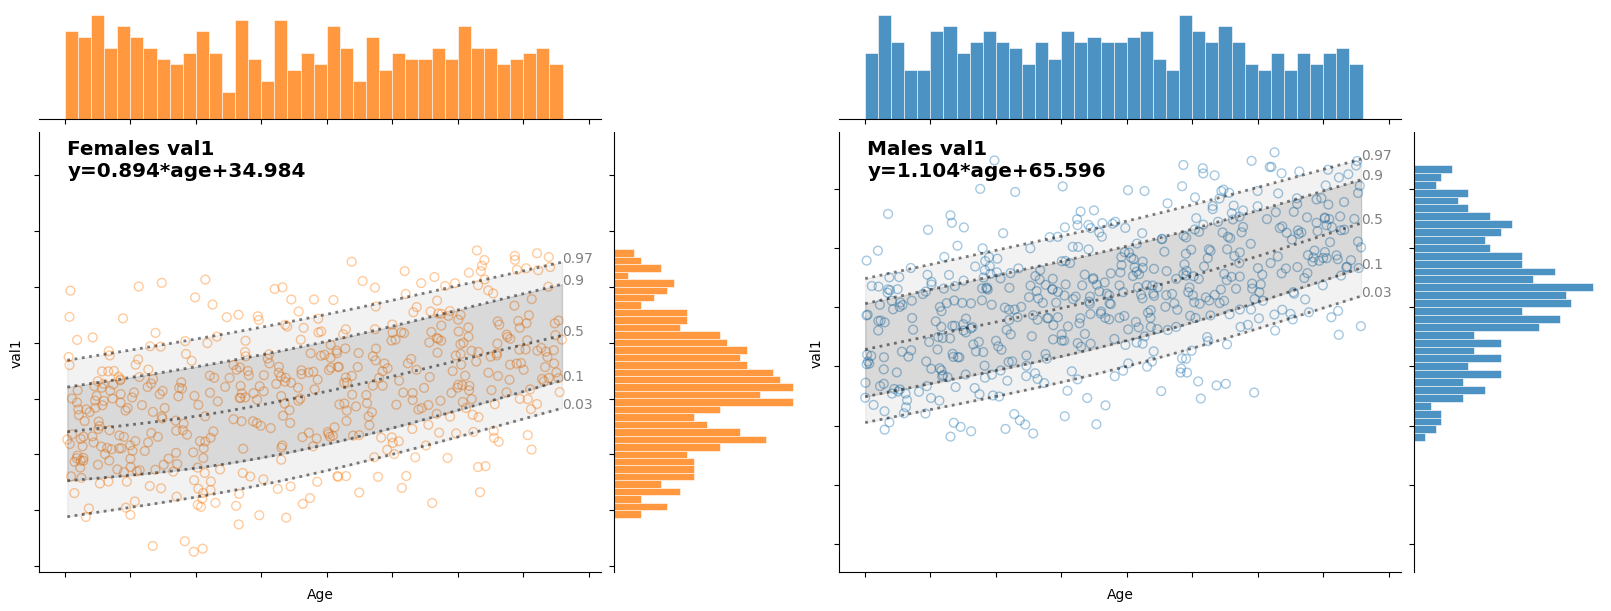

In [62]:
gender_refplots = GenderAgeRefPlot(data, "val1")
gender_refplots.plot()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()